### Imports

In [14]:
from utils import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Everything is in the utils.py file now, this cell is not needed anymore

# import os
# import pyxdf
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from scipy.signal import filtfilt, iirnotch, detrend, butter, cheby1, lfilter, welch, cheb1ord, freqz
# import digital_processing as dp
# import feature_extraction as fe


# def plot_psd(signal, sample_rate):
#     '''
#     Plot the power spectral density of a signal
#     signal: array-like corresponding to the signal
#     sample_rate: int corresponding to the sample rate of the signal in Hz
#     '''
#     f, Pxx_den = welch(signal, fs=sample_rate, window="hamming", nperseg=0.5*2000, noverlap=0.5*2000/2, nfft=sample_rate)
#     plt.plot(f, Pxx_den/np.max(Pxx_den))
#     plt.vlines(50, 0, 1, colors='r', linestyles='--')
#     # plt.vlines(100, 0.5e-3, 1e3, colors='r', linestyles='--')
#     plt.xlabel('frequency [Hz]')
#     plt.ylabel('PSD [V**2/Hz]')
#     plt.show()

# def bandpass_filter(input_signal, sr, lowcut, highcut, order=5):
    
#     nyq = 0.5 * sr # Nyquist frequency
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype="band")
#     output_signal = filtfilt(b, a, input_signal)
    
#     return output_signal

# def NotchF(input, samprate, center, bw):
#     wo = center/(samprate/2)
#     bw = bw / (samprate/2)
#     [b,a] = iirnotch(wo,bw)
#     return filtfilt(b,a,input)

# def filter_signals(emg_stream):
#     # Set variables
#     l_bandpass = 10
#     h_bandpass = 400
#     sample_rate = int(emg_stream['info']['nominal_srate'][0])

#     # Get signal information from the XDF file and apply filters
#     l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
    
#     for i in range(50, 250, 50):
#         l_ear_emg = NotchF(l_ear_emg, sample_rate, i, 5) # Notch filter at harmonics of 50 Hz
#     l_ear_emg = bandpass_filter(detrend(l_ear_emg), sample_rate, l_bandpass, h_bandpass)

#     r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EMG
#     for i in range(50, 250, 50):
#         r_ear_emg = NotchF(r_ear_emg, sample_rate, i, 5) # Notch filter at harmonics of 50 Hz
#     r_ear_emg = bandpass_filter(detrend(r_ear_emg), sample_rate, l_bandpass, h_bandpass)

#     return l_ear_emg, r_ear_emg

# def plot_signal(signal, n_ear = ""):
#     # Plot signals
#     plt.figure(figsize=(10,3))
#     plt.plot(signal)
#     plt.title(f"{n_ear.capitalize()}")

#     plt.show()

# def structure_data(emg_stream, EMGinfo_stream, ear_class, ear_emg, sample_rate, time_window=0.5):
#     '''
#     This function will:
#         Check if the classification stream starts earlier, in that case, don't take into account all classification data that starts before
#         Create a DataFrame where the class label, the index and the emg data for the time window will be stored, there will be as many columns as needed. If the time window 
#         is 500 ms and the sampling rate is 2000 Hz, there will be 1000 columns corresponding to each sEMG recording
    
#     :param emg_stream: xdf stream containing the EMG data
#     :param EMGinfo_stream: xdf stream containing the classification data
#     :param ear_class: array containing the class labels for one ear
#     :param ear_emg: array containing the ear EMG data for one ear
#     :param sample_rate: int corresponding to the sampling rate of the EMG data recording
#     :param time_window: float corresponding to the time window we want to extract in seconds

#     '''

#     if emg_stream["time_stamps"][0] - EMGinfo_stream["time_stamps"][0] > 0: # This condition is true when EMG signal starts recording AFTER the classification, which makes no sense

#         # Find the closest timestamp in the EMGinfo stream to the first timestamp in the EMG stream
#         emg_first_timestamp = emg_stream["time_stamps"][0]
#         emginfo_timestamps = EMGinfo_stream["time_stamps"]

#         closest_index = np.abs(emginfo_timestamps - emg_first_timestamp).argmin()
#         print(f"EMG stream starts after classification stream. Closest index: {closest_index}")
#     else:
#         closest_index = 0
#         print(f"EMG stream starts at the same time as the classification stream. Closest index: {closest_index}")
    
    
#     # This code will extract a window of EMG data before each class label in the EMGinfo stream and store it in a DataFrame
#     # Corresponding number of samples based on frequency and the time window
#     samples_window = int(sample_rate * time_window)

#     # Create an empty DataFrame
#     columns = ['class_label'] + ["stream_idx"] + [f'emg_{i}' for i in range(samples_window)]
#     df = pd.DataFrame(columns=columns)

#     for class_time, class_label in zip(EMGinfo_stream['time_stamps'][closest_index:], ear_class[closest_index:]): # There was a bug here, the ear_class was considering all the values, not only the ones after the closest_index
#         # Find the closest timestamp in the EMG stream
#         idx = np.abs(emg_stream['time_stamps'] - class_time).argmin()
        
#         # Check if we can extract a full window of data without going out of bounds, append the data only if we're in bounds
#         if idx >= samples_window:
#             # Extract EMG data for the window
#             emg_data_window = ear_emg[idx - samples_window:idx]
            
#             # Append to the DataFrame
#             row_data = [class_label] + [idx] + emg_data_window.tolist()
#             df.loc[len(df)] = row_data
    
#     return df

# def get_features(ear_df, sample_rate, time_window=0.5, name=""):

#     frame = int(time_window*sample_rate) # Number of samples in the time window

#     ear_df_values = ear_df.iloc[:, 2:].values # Get the values of the EMG data from the 2nd column onwards

#     output_df = pd.DataFrame()  # Create an empty dataframe to store the outputs

#     for row in ear_df_values:
#         features_df, _ = fe.features_estimation(row, name, sample_rate, frame, step=1, plot=False, verbose=False)  # Call the features_estimation function
#         '''
#         The step parameter that is passed to the features_estimation function makes reference to the number of samples that will be taken into account to compute the features. This is
#         because the code provided is meant to be used as a sliding window, so the step parameter will determine how many samples will be taken into account to compute the features for the
#         whole signal. In this case, we are passing 1, which means that we are taking all the samples into account to compute the features because we already split the signal into windows as 
#         one row of the ear_df dataframe corresponds to one window of the signal.
#         '''
#         output_df = pd.concat([output_df, features_df], axis=1)  # Concatenate the features dataframe to the output dataframe column by column

#     return pd.concat([ear_df.reset_index(drop=True), output_df.T.reset_index(drop=True)], axis=1) # Concatenate the output dataframe with the original dataframe

# def filter_signals_2(emg_stream):

#     # Set variables
#     l_bandpass = 10
#     h_bandpass = 400
#     sample_rate = int(emg_stream['info']['nominal_srate'][0])

#     l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
#     r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EM

#     # Filter the 50Hz armonics (50, 100, 150, 200 Hz)
#     for i in range(50, 250, 50):
#         l_ear_emg = dp.notch_filter(l_ear_emg, sample_rate, i, False)
#         r_ear_emg = dp.notch_filter(r_ear_emg, sample_rate, i, False)

#     # Apply bandpass filters 
#     l_ear_bandpass = dp.bp_filter(detrend(l_ear_emg), l_bandpass, h_bandpass, sample_rate, False)
#     r_ear_bandpass = dp.bp_filter(detrend(r_ear_emg), l_bandpass, h_bandpass, sample_rate, False)

#     # Apply wavelet denoising
#     l_ear_denoise = dp.denoisewavelet(l_ear_bandpass)
#     r_ear_denoise = dp.denoisewavelet(r_ear_bandpass)
    
#     return l_ear_denoise, r_ear_denoise

# def process_xdf(path):
    
#     folders = path.split("/")[:-1]
#     folder = "/".join(folders)
    
#     csv_file_l = folder + '/l_ear_features_' + folders[-1] + '.csv'
#     csv_file_r = folder + '/r_ear_features_' + folders[-1] + '.csv'

#     print(f"Data in folder {folder} is being processed.")

#     print("Checking if csv files exist.")
#     if os.path.exists(csv_file_l) and os.path.exists(csv_file_r):
#         print("Files exist. Loading csv files.")
#         l_ear_features_df = pd.read_csv(csv_file_l)
#         r_ear_features_df = pd.read_csv(csv_file_r)
    
#     else:
#         print("Files do not exist. Creating csv files.")
#         data, _ = pyxdf.load_xdf(path)

#         EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
#         emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

#         sample_rate = int(emg_stream['info']['nominal_srate'][0])
#         time_window = 0.5

#         l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
#         l_ear_class = EMGinfo_stream["time_series"][:, 6]
#         r_ear_class = EMGinfo_stream["time_series"][:, 7]

#         l_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate)
#         r_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=r_ear_class, ear_emg=r_ear_emg, sample_rate=sample_rate)

#         l_ear_features_df = get_features(l_ear_df, sample_rate, time_window, "left")
#         r_ear_features_df = get_features(r_ear_df, sample_rate, time_window, "right")
#         l_ear_features_df.to_csv(folder + '/l_ear_features_' + folders[-1] + '.csv', index=False)
#         r_ear_features_df.to_csv(folder + '/r_ear_features_' + folders[-1] + '.csv', index=False)

#     return l_ear_features_df, r_ear_features_df


Stream 6: Calculated effective sampling rate 6.6649 Hz is different from specified rate 20.0000 Hz.
Stream 12: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 8: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 6.7235 Hz is different from specified rate 500.0000 Hz.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\pyyawt\dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


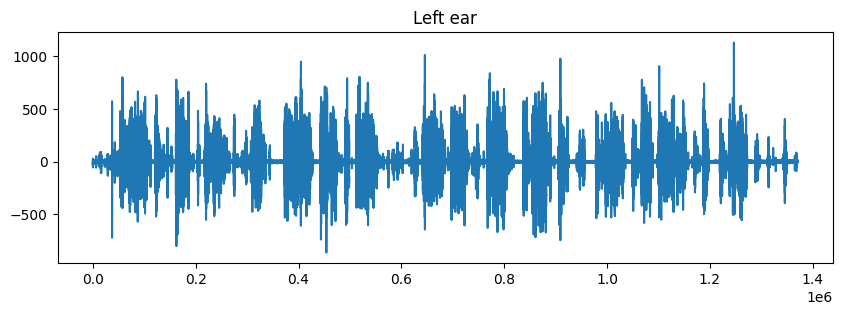

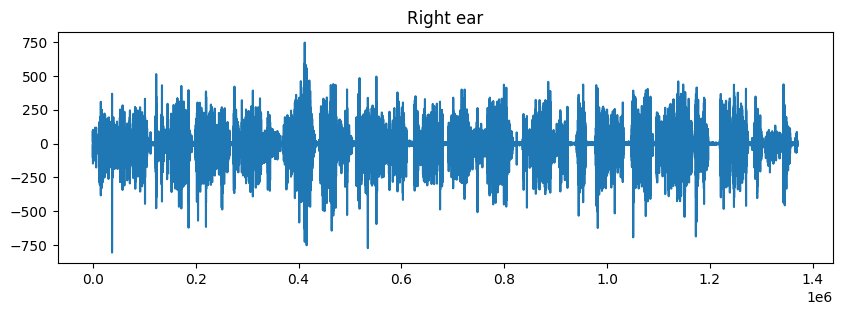

In [3]:
data, header = pyxdf.load_xdf("Data/AM001/s2/sub-AM001_s2_task6.xdf")

EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

sample_rate = int(emg_stream['info']['nominal_srate'][0])

l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
l_ear_class = EMGinfo_stream["time_series"][:, 6]
r_ear_class = EMGinfo_stream["time_series"][:, 7]
plot_signal(l_ear_emg, "left ear")
plot_signal(r_ear_emg, "right ear")


In [32]:
features_df = get_features(l_ear_df, sample_rate, 0.5, "left")
display(features_df)

class_label  stream_idx     emg_0     emg_1     emg_2     emg_3  \
0             0.0      1217.0  6.612857  6.292471  5.961408  5.603150   
1             0.0      1517.0 -3.561631 -3.664661 -3.786912 -3.901276   
2             0.0      1817.0 -7.599800 -7.711182 -7.789236 -7.815258   
3             0.0      2117.0 -3.633665 -3.231558 -2.822267 -2.360677   
4             0.0      2418.0 -0.070667  0.199697  0.444346  0.677603   
...           ...         ...       ...       ...       ...       ...   
4532          0.0   1361414.0 -1.342401 -1.400906 -1.448638 -1.471362   
4533          0.0   1361714.0  2.486789  2.922562  3.333524  3.723989   
4534          0.0   1362014.0  1.187225  1.083868  0.970203  0.854447   
4535          0.0   1362314.0 -3.832424 -3.784228 -3.702974 -3.629925   
4536          0.0   1362614.0  4.014241  3.955937  3.884362  3.800273   

         emg_4     emg_5     emg_6     emg_7  ...    ZC  WAMP   MYOP  \
0     5.195337  4.787013  4.394972  3.924103  ...  20.0   0.0  0.000   
1    -4.000067 -4.071859 -4.099301 -4.108311  ...  21.0   0.0  0.000   
2    -7.777105 -7.677668 -7.510225 -7.312284  ...  22.0   0.0  0.000   
3    -1.820814 -1.207181 -0.500789  0.267346  ...  22.0   0.0  0.000   
4     0.865253  0.998255  1.104744  1.194872  ...  25.0   0.0  0.000   
...        ...       ...       ...       ...  ...   ...   ...    ...   
4532 -1.472161 -1.440769 -1.395391 -1.349745  ...  21.0   0.0  0.007   
4533  4.075355  4.379695  4.660260  4.928466  ...  19.0   0.0  0.004   
4534  0.734014  0.613335  0.487132  0.350878  ...  15.0   0.0  0.000   
4535 -3.515932 -3.360834 -3.201626 -3.050103  ...  17.0   0.0  0.000   
4536  3.703088  3.593844  3.467606  3.320769  ...  20.0   0.0  0.000   

              FR        MNP            TP        MNF        MDF        PKF  \
0     298.096169  24.018973  12273.695272  21.854989  21.484375  13.671875   
1     462.294694  22.406751  11449.849667  20.356468  19.531250  15.625000   
2     156.157399  17.000803   8687.410334  21.692655  21.484375  21.484375   
3     616.548348  18.243216   9322.283224  20.985815  19.531250  19.531250   
4      96.905282  16.714883   8541.305467  23.981652  21.484375  27.343750   
...          ...        ...           ...        ...        ...        ...   
4532  204.086435  11.975227   6119.340742  20.556039  19.531250  11.718750   
4533  419.485207  12.093956   6180.011293  19.021512  15.625000  11.718750   
4534  624.386797  12.895295   6589.495945  17.250316  13.671875  11.718750   
4535  209.863798  10.742875   5489.609060  17.040156  13.671875  11.718750   
4536  205.426820  10.963386   5602.290011  19.200075  13.671875  11.718750   

          WENT  
0     0.239013  
1     0.124635  
2     0.121481  
3     0.216382  
4     0.266222  
...        ...  
4532  0.175051  
4533  0.195225  
4534  0.109654  
4535  0.081018  
4536  0.162296  

[4537 rows x 1020 columns]

AttributeError: 'DataFrame' object has no attribute 'colums'

In [ ]:
l_ear_df = pd.read_csv('Data/s2/l_ear_features_s2.csv')
display(l_ear_df)


In [ ]:
l_ear_df

In [ ]:
# l_ear_df_values = l_ear_df.iloc[:, 2:].values # Get the values of the EMG data from the 2nd column onwards

# output_df = pd.DataFrame()  # Create an empty dataframe to store the outputs

# features1, _ = fe.features_estimation(l_ear_df_values[0], "LEFT", sample_rate, 1000, 1)  # Call the features_estimation function
# features2, _ = fe.features_estimation(l_ear_df_values[1], "LEFT", sample_rate, 1000, 1)  # Call the features_estimation function

# output_df = pd.concat([features1, features2], axis=1)  # Concatenate the features dataframe to the output dataframe column by column
# output_df


In [ ]:
# import pandas as pd
# ## ACTUAL TESTING

# l_ear_df_values = l_ear_df.iloc[:, 2:].values # Get the values of the EMG data from the 2nd column onwards

# output_df = pd.DataFrame()  # Create an empty dataframe to store the outputs

# for row in l_ear_df_values:
#     features_df, _ = fe.features_estimation(row, "LEFT", sample_rate, 1000, 1)  # Call the features_estimation function
#     output_df = pd.concat([output_df, features_df], axis=1)  # Concatenate the features dataframe to the output dataframe column by column

# # output_df.columns = range(output_df.shape[1])  # Reset the column names to numeric indices



In [ ]:
l_ear_features_df, r_ear_feature_df = process_xdf("Data/s2/sub-AM001_s2_task6")
l_ear_features_df = l_ear_features_df.iloc[:, 1002:]
r_ear_feature_df = r_ear_feature_df.iloc[:, 1002:]
display(l_ear_features_df)
display(r_ear_feature_df)

In [ ]:
l_ear_features_df

## Debug problem with class labels

In [2]:
data, _ = pyxdf.load_xdf("Data/AM001/s2/sub-AM001_s2_task6.xdf")

EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

sample_rate = int(emg_stream['info']['nominal_srate'][0])
time_window = 0.5

l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
l_ear_class = EMGinfo_stream["time_series"][:, 6]
r_ear_class = EMGinfo_stream["time_series"][:, 7]

# l_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate)
# r_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=r_ear_class, ear_emg=r_ear_emg, sample_rate=sample_rate)

Stream 6: Calculated effective sampling rate 6.6649 Hz is different from specified rate 20.0000 Hz.
Stream 12: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 8: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 6.7235 Hz is different from specified rate 500.0000 Hz.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\pyyawt\dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


In [3]:
print("Delay in start of classification - recording:", EMGinfo_stream["time_stamps"][0] - emg_stream["time_stamps"][0])
print("Start of classification:", EMGinfo_stream["time_stamps"][0])
print("Start of sEMG recording:", emg_stream["time_stamps"][0])
print("")
print("Size of classification:", len(EMGinfo_stream["time_stamps"]), "samples")
print("Sample rate of classification:", EMGinfo_stream["info"]["effective_srate"])
print("Seconds recorded of classification:", len(EMGinfo_stream["time_stamps"])/EMGinfo_stream["info"]["effective_srate"])
print("")
print("Size of sEMG recording:", len(emg_stream["time_stamps"]), "samples")
print("Sample rate of sEMG recording:", emg_stream["info"]["effective_srate"])
print("Seconds recorded of sEMG recording:", len(emg_stream["time_stamps"])/emg_stream["info"]["effective_srate"])


Delay in start of classification - recording: -3.5932434220449068
Start of classification: 147963.3794202437
Start of sEMG recording: 147966.97266366574

Size of classification: 4565 samples
Sample rate of classification: 6.664865901487771
Seconds recorded of classification: 684.9350110676605

Size of sEMG recording: 1370029 samples
Sample rate of sEMG recording: 2000.045430873169
Seconds recorded of sEMG recording: 684.9989399500191


7


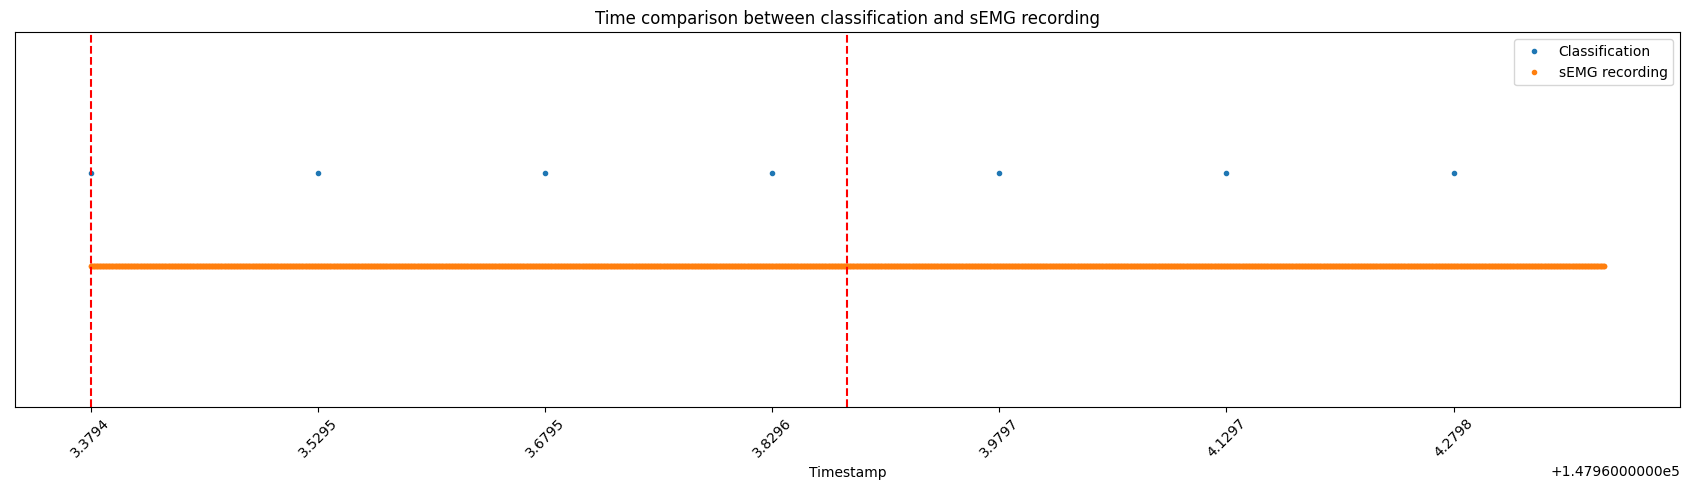

In [19]:
# Remove offset
time_offset = EMGinfo_stream["time_stamps"][0] - emg_stream["time_stamps"][0]
adjusted_emg_timestamps = emg_stream["time_stamps"] - np.abs(time_offset)

stamp = adjusted_emg_timestamps[0] + 1 # one second after the start of the recording

index_info = next(x[0] for x in enumerate(EMGinfo_stream["time_stamps"]) if x[1] > stamp)
index_EMG = next(x[0] for x in enumerate(adjusted_emg_timestamps) if x[1] > stamp)
print(index_info)

plt.figure(figsize=(17,5))

plt.plot(EMGinfo_stream["time_stamps"][:index_info], [0.25] * len(EMGinfo_stream["time_stamps"][:index_info]), '.', label="Classification")
plt.plot(adjusted_emg_timestamps[:index_EMG], [-0.25] * len(adjusted_emg_timestamps[:index_EMG]), '.', label="sEMG recording")

# Draw vertical lines at each 0.5 increment on the x-axis
x_min = min(min(EMGinfo_stream["time_stamps"][:index_info]), min(adjusted_emg_timestamps[:index_EMG]))
x_max = max(max(EMGinfo_stream["time_stamps"][:index_info]), max(adjusted_emg_timestamps[:index_EMG]))
x_values = np.arange(x_min, x_max, 0.5)
for x in x_values:
    plt.axvline(x=x, color='r', linestyle='--')

plt.ylim(-1, 1)  # Set the y-axis limits to show the points horizontally
plt.xlabel('Timestamp')
# plt.ylabel('Points')
plt.xticks(EMGinfo_stream["time_stamps"][:index_info], rotation=45)
plt.yticks([])
plt.title('Time comparison between classification and sEMG recording')
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
def debug_structure_data(emg_stream, EMGinfo_stream, ear_class, ear_emg, sample_rate, time_window=0.5):
    
    time_offset = EMGinfo_stream["time_stamps"][0] - emg_stream["time_stamps"][0]
    adjusted_emg_timestamps = emg_stream["time_stamps"] - np.abs(time_offset)
    
    # This code will extract a window of EMG data before each class label in the EMGinfo stream and store it in a DataFrame
    # Corresponding number of samples based on frequency and the time window
    samples_window = int(sample_rate * time_window)

    # Create an empty DataFrame
    columns = ['class_label'] + ["stream_idx"] + [f'emg_{i}' for i in range(samples_window)]
    df = pd.DataFrame(columns=columns)

    for class_time, class_label in zip(EMGinfo_stream['time_stamps'], ear_class):
        # Find the closest timestamp in the EMG stream
        idx = np.abs(adjusted_emg_timestamps - class_time).argmin()
        
        # Check if we can extract a full window of data without going out of bounds
        if idx >= samples_window:
            # Extract EMG data for the window
            emg_data_window = ear_emg[idx - samples_window:idx]
            
            # Append to the DataFrame
            row_data = [class_label] + [idx] + emg_data_window.tolist()
            df.loc[len(df)] = row_data
    
    return df


l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
l_ear_class = EMGinfo_stream["time_series"][:, 6]
r_ear_class = EMGinfo_stream["time_series"][:, 7]

debug_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate,
                                time_window=0.5)
display(debug_df)

EMG stream starts after classification stream. Closest index: 24


class_label  stream_idx     emg_0     emg_1     emg_2     emg_3  \
0             0.0      1217.0  6.612857  6.292471  5.961408  5.603150   
1             0.0      1517.0 -3.561631 -3.664661 -3.786912 -3.901276   
2             0.0      1817.0 -7.599800 -7.711182 -7.789236 -7.815258   
3             0.0      2117.0 -3.633665 -3.231558 -2.822267 -2.360677   
4             0.0      2418.0 -0.070667  0.199697  0.444346  0.677603   
...           ...         ...       ...       ...       ...       ...   
4532          0.0   1361414.0 -1.342401 -1.400906 -1.448638 -1.471362   
4533          0.0   1361714.0  2.486789  2.922562  3.333524  3.723989   
4534          0.0   1362014.0  1.187225  1.083868  0.970203  0.854447   
4535          0.0   1362314.0 -3.832424 -3.784228 -3.702974 -3.629925   
4536          0.0   1362614.0  4.014241  3.955937  3.884362  3.800273   

         emg_4     emg_5     emg_6     emg_7  ...   emg_990   emg_991  \
0     5.195337  4.787013  4.394972  3.924103  ...  1.337778  1.386896   
1    -4.000067 -4.071859 -4.099301 -4.108311  ...  2.257197  2.353527   
2    -7.777105 -7.677668 -7.510225 -7.312284  ... -1.683243 -1.660677   
3    -1.820814 -1.207181 -0.500789  0.267346  ... -4.325999 -4.195679   
4     0.865253  0.998255  1.104744  1.194872  ...  7.744310  8.312569   
...        ...       ...       ...       ...  ...       ...       ...   
4532 -1.472161 -1.440769 -1.395391 -1.349745  ...  5.488941  5.620631   
4533  4.075355  4.379695  4.660260  4.928466  ... -2.007863 -2.224652   
4534  0.734014  0.613335  0.487132  0.350878  ... -3.631762 -3.554894   
4535 -3.515932 -3.360834 -3.201626 -3.050103  ...  0.232333  0.304574   
4536  3.703088  3.593844  3.467606  3.320769  ...  4.188829  4.094866   

       emg_992   emg_993   emg_994    emg_995    emg_996    emg_997  \
0     1.484730  1.611017  1.796780   2.012858   2.232039   2.510052   
1     2.460107  2.557635  2.646625   2.730066   2.803732   2.873775   
2    -1.623693 -1.571231 -1.505537  -1.417091  -1.298955  -1.155146   
3    -4.044828 -3.863466 -3.650797  -3.407076  -3.129366  -2.819293   
4     8.842926  9.314760  9.740447  10.130283  10.450557  10.689069   
...        ...       ...       ...        ...        ...        ...   
4532  5.752522  5.888288  6.004857   6.089613   6.144106   6.158351   
4533 -2.416545 -2.565440 -2.693659  -2.813992  -2.901080  -2.950796   
4534 -3.452872 -3.323269 -3.179673  -3.032127  -2.877494  -2.721226   
4535  0.379783  0.453302  0.536281   0.636311   0.746261   0.867367   
4536  4.006803  3.928483  3.844891   3.746196   3.636682   3.511244   

        emg_998    emg_999  
0      2.862240   3.210705  
1      2.943570   3.003486  
2     -0.983413  -0.794092  
3     -2.477304  -2.097275  
4     10.881864  11.045118  
...         ...        ...  
4532   6.149281   6.129183  
4533  -2.972639  -2.965775  
4534  -2.556839  -2.378787  
4535   0.986256   1.090228  
4536   3.378990   3.247778  

[4537 rows x 1002 columns]

In [46]:
fix = True
n_rows_over_200_after_fix = []


for cls in [0,1,2]:
    class_df = debug_df[debug_df["class_label"] == cls]

    filtered_df = class_df[class_df.iloc[:, 2:].max(axis=1) > 200]
    print(f"Number of rows over 200 mV in class {cls}: {filtered_df.shape[0]}")
    if fix:
        n_rows_over_200_after_fix.append(filtered_df.shape[0])



Number of rows over 200 mV in class 0: 307
Number of rows over 200 mV in class 1: 346
Number of rows over 200 mV in class 2: 352


In [47]:
print(n_rows_over_200_before_fix)
print(n_rows_over_200_after_fix)

[514, 252, 239]
[307, 346, 352]


In [13]:
class_2_df = debug_df[debug_df["class_label"] == 2]
display(class_2_df)

n_rows = 10
n_cols = 60
fig, axes = plt.subplots(n_rows, n_cols, figsize=(100, 100), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

# Plot each row in its respective subplot
for i, (idx, row) in enumerate(class_2_df.iterrows()):
    if i >= n_rows * n_cols:
        break  # Avoid indexing error if there are more rows than subplots
    ax = axes[i]
    ax.plot(row[2:], color='blue')  # You can customize the color and line style
    ax.set_xticks([])  # Optional: Remove x-axis ticks for cleanliness
    # ax.set_yticklabels([])  # Optional: Remove y-axis labels for cleanliness

# Hide any unused subplots
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

class_label  stream_idx      emg_0      emg_1      emg_2      emg_3  \
184           2.0     56441.0  10.031656  10.677106  11.245790  11.633943   
185           2.0     56741.0   6.250012   5.509334   4.717719   3.846399   
193           2.0     59142.0   6.203346   5.727486   5.189911   4.552329   
194           2.0     59443.0   4.746965   5.078217   5.382207   5.630501   
195           2.0     59743.0  -1.206739  -1.253569  -1.284113  -1.303371   
...           ...         ...        ...        ...        ...        ...   
4223          2.0   1268673.0  -3.586294  -3.606708  -3.592859  -3.559003   
4224          2.0   1268973.0  -0.239212  -0.645649  -1.083290  -1.521053   
4247          2.0   1275876.0  -2.295807  -2.295225  -2.286440  -2.269880   
4248          2.0   1276177.0  -4.144500  -3.853729  -3.581757  -3.312185   
4249          2.0   1276477.0   4.891160   4.704280   4.459854   4.192089   

          emg_4      emg_5      emg_6      emg_7  ...   emg_990   emg_991  \
184   11.769796  11.690709  11.369557  10.959961  ...  7.383928  7.027306   
185    2.875369   1.808977   0.635322  -0.632708  ...  1.020018  1.453377   
193    3.817429   2.951305   2.017167   1.059675  ... -0.001502  0.132755   
194    5.813816   5.957623   6.071948   6.151350  ... -8.991190 -9.880473   
195   -1.300995  -1.285451  -1.265316  -1.221621  ...  3.902123  3.841087   
...         ...        ...        ...        ...  ...       ...       ...   
4223  -3.514474  -3.443815  -3.345101  -3.226366  ... -2.997432 -2.983513   
4224  -1.940334  -2.337769  -2.696359  -3.033464  ... -0.921309 -0.987000   
4247  -2.242460  -2.200899  -2.146681  -2.078855  ... -5.232455 -4.892147   
4248  -3.034748  -2.770114  -2.522248  -2.278579  ... -1.351661 -1.237408   
4249   3.927827   3.658237   3.396897   3.129693  ... -0.467758 -0.309780   

        emg_992    emg_993    emg_994    emg_995    emg_996    emg_997  \
184    7.644505   9.011541  11.347258  12.869096  12.122197   7.388532   
185    1.906898   2.397601   2.934350   3.476176   3.998100   4.508107   
193    0.227813   0.269183   0.333065   0.459163   0.640957   0.910426   
194  -10.652989 -11.363560 -12.043650 -12.625392 -13.095636 -13.483658   
195    3.729487   3.594231   3.458094   3.312167   3.166550   3.011495   
...         ...        ...        ...        ...        ...        ...   
4223  -2.965400  -2.941941  -2.915875  -2.883139  -2.840555  -2.792822   
4224  -1.046493  -1.113049  -1.186435  -1.258826  -1.328712  -1.392117   
4247  -4.514035  -4.096672  -3.643428  -3.156564  -2.617089  -2.012039   
4248  -1.129116  -1.028601  -0.944654  -0.867020  -0.789392  -0.724630   
4249  -0.135544   0.066817   0.301651   0.535336   0.746341   0.937558   

        emg_998    emg_999  
184   -3.717940  -0.232839  
185    4.990655   5.476268  
193    1.206424   1.484344  
194  -13.790107 -14.014376  
195    2.837147   2.662691  
...         ...        ...  
4223  -2.740561  -2.678232  
4224  -1.443840  -1.492262  
4247  -1.343904  -0.604671  
4248  -0.675199  -0.633776  
4249   1.093865   1.233582  

[687 rows x 1002 columns]

c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  from ipykernel import kernelapp as app
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  from ipykernel import kernelapp as app
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  from ipykernel import kernelapp as app
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-

c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is dep

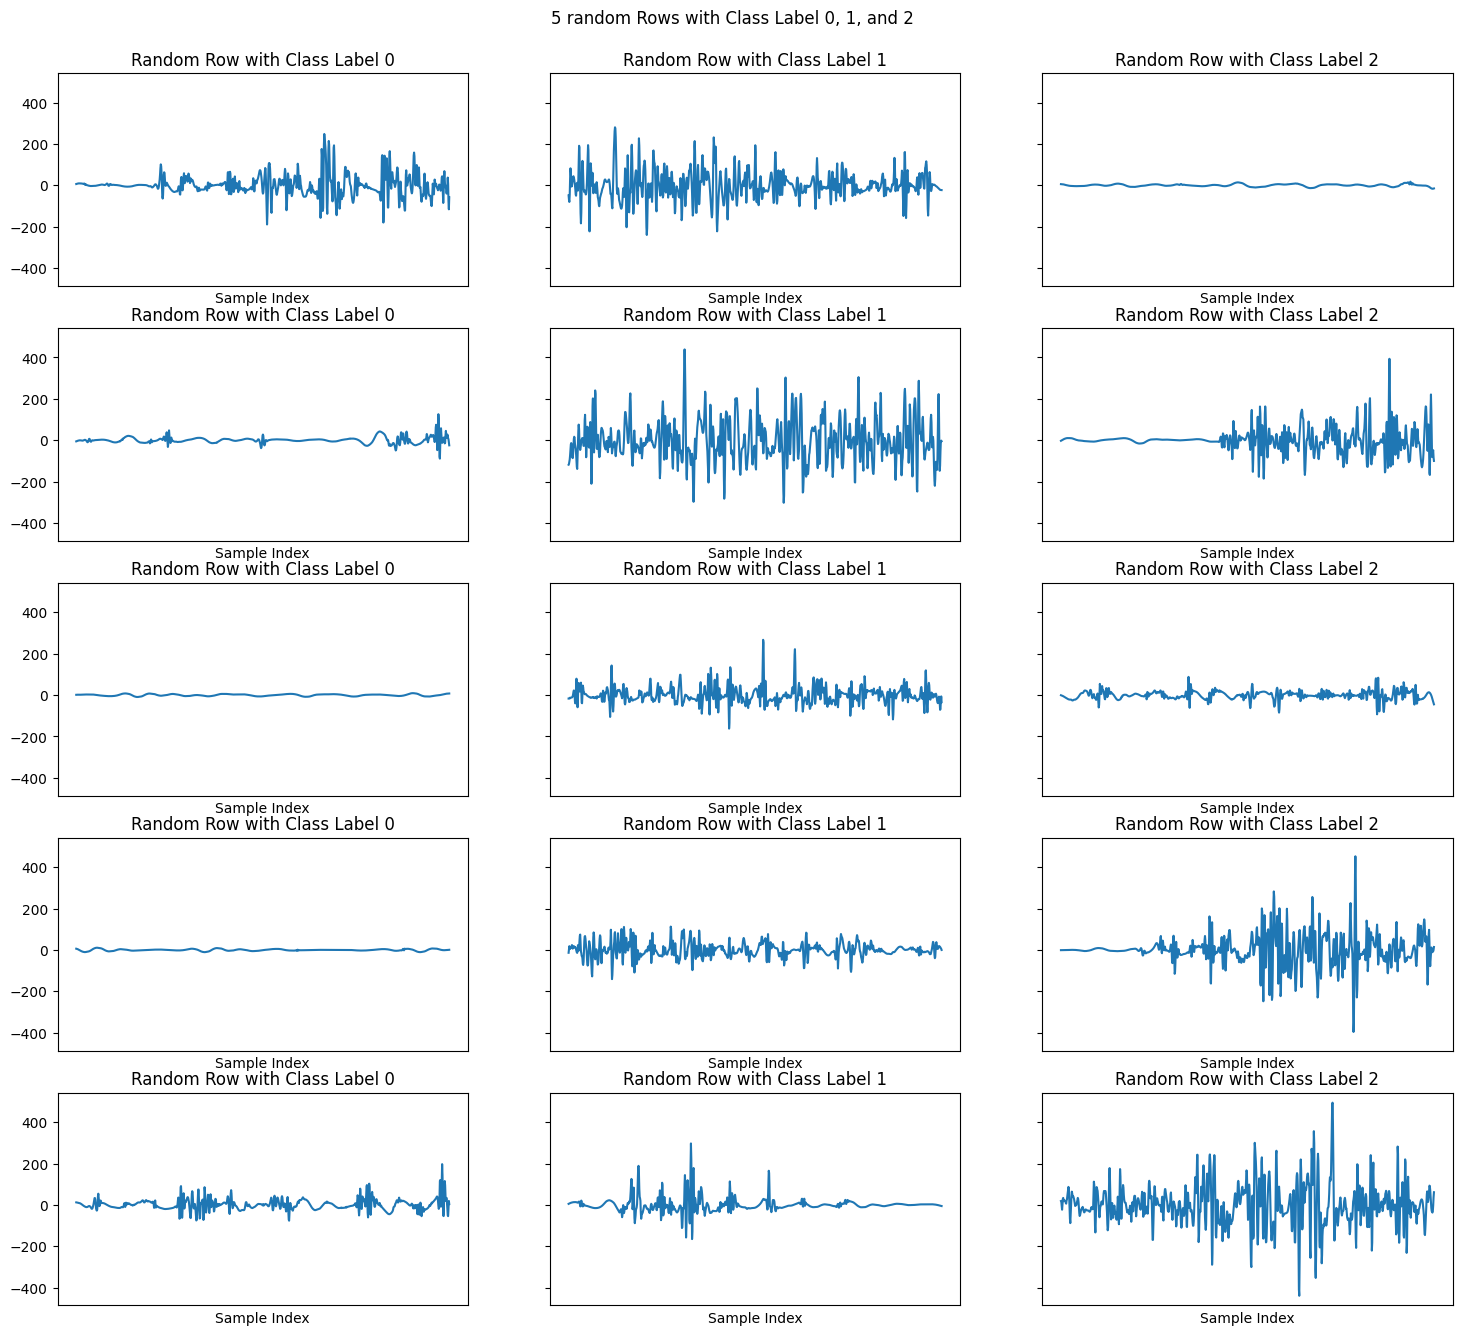

In [13]:
import random
# Create a figure for the subplots
# plt.figure(figsize=(18, 10))  # Increase figure size for better visibility

# Create a figure for the subplots
fig, axs = plt.subplots(5, 3, figsize=(18, 16), sharey=True, sharex=True)  # Share Y-axis across all subplots

for row in range(5):
    for idx, label in enumerate([0, 1, 2]):
        # Filter and sample data
        filtered_df = debug_df[debug_df["class_label"] == label]
        random_rows = filtered_df.sample(n=1)

        # Plot on the respective subplot
        for i in range(random_rows.shape[0]):
            axs[row, idx].plot(random_rows.iloc[i, 2:1000], label=f'Row {i+1}')

        # axs[row,idx].legend()
        axs[row,idx].set_title(f'Random Row with Class Label {label}')
        axs[row,idx].set_xlabel('Sample Index')
        axs[row,idx].set_xticks([])  # Hide x-axis ticks

plt.suptitle("5 random Rows with Class Label 0, 1, and 2", y=0.92)  # Set the title for the entire figure
plt.show()


### Test ML models after the [closest_index:] fix

In [20]:
def balance_dataset(df):
    # Pick 70% of the rows with class_label 0

    # Filter the rows where class_label is 0
    class_0_df = df[df['class_label'] == 0]

    # Randomly sample 70% of these rows
    class_0_sampled_df = class_0_df.sample(frac=0.3)

    # Filter the rows where class_label is not 0
    non_class_0_df = df[df['class_label'] != 0]

    # Concatenate the down-sampled class 0 DataFrame with the non-class 0 DataFrame
    balanced_df = pd.concat([class_0_sampled_df, non_class_0_df])

    # Shuffle the rows of the DataFrame
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    return balanced_df

l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
l_ear_class = EMGinfo_stream["time_series"][:, 6]
r_ear_class = EMGinfo_stream["time_series"][:, 7]

debug_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate, time_window=0.5)
debug_df = get_features(debug_df, sample_rate, 0.5, "left")
display(debug_df)

c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\pyyawt\dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


EMG stream starts after classification stream. Closest index: 24


class_label  stream_idx     emg_0     emg_1     emg_2     emg_3  \
0             0.0      1217.0  6.612857  6.292471  5.961408  5.603150   
1             0.0      1517.0 -3.561631 -3.664661 -3.786912 -3.901276   
2             0.0      1817.0 -7.599800 -7.711182 -7.789236 -7.815258   
3             0.0      2117.0 -3.633665 -3.231558 -2.822267 -2.360677   
4             0.0      2418.0 -0.070667  0.199697  0.444346  0.677603   
...           ...         ...       ...       ...       ...       ...   
4532          0.0   1361414.0 -1.342401 -1.400906 -1.448638 -1.471362   
4533          0.0   1361714.0  2.486789  2.922562  3.333524  3.723989   
4534          0.0   1362014.0  1.187225  1.083868  0.970203  0.854447   
4535          0.0   1362314.0 -3.832424 -3.784228 -3.702974 -3.629925   
4536          0.0   1362614.0  4.014241  3.955937  3.884362  3.800273   

         emg_4     emg_5     emg_6     emg_7  ...    ZC  WAMP   MYOP  \
0     5.195337  4.787013  4.394972  3.924103  ...  20.0   0.0  0.000   
1    -4.000067 -4.071859 -4.099301 -4.108311  ...  21.0   0.0  0.000   
2    -7.777105 -7.677668 -7.510225 -7.312284  ...  22.0   0.0  0.000   
3    -1.820814 -1.207181 -0.500789  0.267346  ...  22.0   0.0  0.000   
4     0.865253  0.998255  1.104744  1.194872  ...  25.0   0.0  0.000   
...        ...       ...       ...       ...  ...   ...   ...    ...   
4532 -1.472161 -1.440769 -1.395391 -1.349745  ...  21.0   0.0  0.007   
4533  4.075355  4.379695  4.660260  4.928466  ...  19.0   0.0  0.004   
4534  0.734014  0.613335  0.487132  0.350878  ...  15.0   0.0  0.000   
4535 -3.515932 -3.360834 -3.201626 -3.050103  ...  17.0   0.0  0.000   
4536  3.703088  3.593844  3.467606  3.320769  ...  20.0   0.0  0.000   

              FR        MNP            TP        MNF        MDF        PKF  \
0     298.096169  24.018973  12273.695272  21.854989  21.484375  13.671875   
1     462.294694  22.406751  11449.849667  20.356468  19.531250  15.625000   
2     156.157399  17.000803   8687.410334  21.692655  21.484375  21.484375   
3     616.548348  18.243216   9322.283224  20.985815  19.531250  19.531250   
4      96.905282  16.714883   8541.305467  23.981652  21.484375  27.343750   
...          ...        ...           ...        ...        ...        ...   
4532  204.086435  11.975227   6119.340742  20.556039  19.531250  11.718750   
4533  419.485207  12.093956   6180.011293  19.021512  15.625000  11.718750   
4534  624.386797  12.895295   6589.495945  17.250316  13.671875  11.718750   
4535  209.863798  10.742875   5489.609060  17.040156  13.671875  11.718750   
4536  205.426820  10.963386   5602.290011  19.200075  13.671875  11.718750   

          WENT  
0     0.239013  
1     0.124635  
2     0.121481  
3     0.216382  
4     0.266222  
...        ...  
4532  0.175051  
4533  0.195225  
4534  0.109654  
4535  0.081018  
4536  0.162296  

[4537 rows x 1020 columns]

Cross-validation score, MEAN: 0.5326530612244897 with STD: 0.05356899897308851
              precision    recall  f1-score   support

         0.0       0.64      0.73      0.69       184
         1.0       0.47      0.43      0.45       166
         2.0       0.48      0.44      0.46       140

    accuracy                           0.55       490
   macro avg       0.53      0.53      0.53       490
weighted avg       0.54      0.55      0.54       490



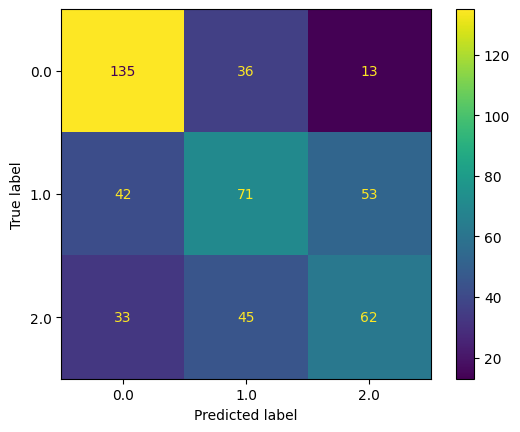

In [35]:
debug_balanced_df = balance_dataset(debug_df)

X = debug_balanced_df.iloc[:, 1002:].values
y = debug_balanced_df['class_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the date (remove mean and scale to unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc_bal_model = svm.SVC(kernel='rbf', class_weight='balanced')
svc_bal_model.fit(X_train_scaled, y_train)

cv_score = cross_val_score(svc_bal_model, X_test_scaled, y_test, cv=10)
print("Cross-validation score, MEAN:", cv_score.mean(), "with STD:", cv_score.std())

y_pred = svc_bal_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=svc_bal_model.classes_)
disp.plot()
plt.show()

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68       184
         1.0       0.43      0.34      0.38       166
         2.0       0.32      0.45      0.37       140

    accuracy                           0.48       490
   macro avg       0.49      0.47      0.48       490
weighted avg       0.51      0.48      0.49       490



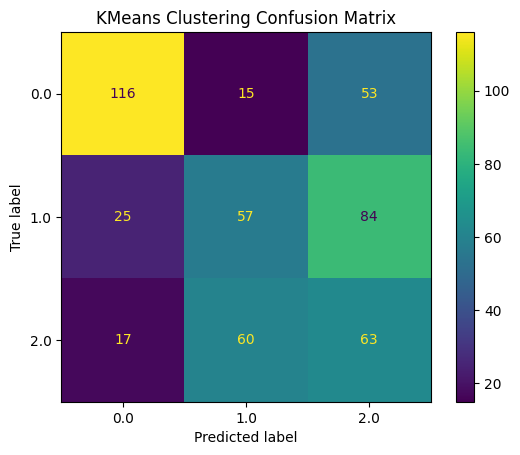

In [39]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X_train_scaled)    
km_pred = kmeans_model.predict(X_test_scaled)
print(classification_report(y_test, km_pred))

dispcm_kmeans = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, km_pred), display_labels=svc_bal_model.classes_)
dispcm_kmeans.plot()
plt.title("KMeans Clustering Confusion Matrix")
plt.show()


In [52]:
print(len(km_pred))
print(len(y_test))
display(pd.DataFrame(X_test, columns=debug_df.columns[1002:]))

490
490


VAR         RMS           IEMG         MAV       LOG  \
0    12054.048622  109.791048   77773.608365   77.773608  5.053748   
1       46.024262    6.788877    5555.762671    5.555763  1.769690   
2     4958.798325   70.418995   50653.050952   50.653051  4.406519   
3    35490.855343  188.400460  133686.177581  133.686178  5.939846   
4     6187.393696   78.662394   36822.063057   36.822063  2.195400   
..            ...         ...            ...         ...       ...   
485    857.727739   29.287254   18971.354771   18.971355  2.552185   
486     13.433731    3.665212    2853.801469    2.853801  1.325272   
487  10229.005168  101.148609   76877.331247   76.877331  5.427495   
488  21618.563503  147.033447  100622.137566  100.622138  5.039679   
489    914.777356   30.245459   17078.168905   17.078169  2.397473   

               WL        ACC       DASDV     ZC  WAMP   MYOP          FR  \
0    46609.261362  46.609261   67.724091  181.0   2.0  0.004    3.255007   
1      437.324271   0.437324    0.564736   26.0   0.0  0.000  265.289725   
2    29683.637127  29.683637   42.934557  182.0   0.0  0.010    3.604320   
3    71676.749718  71.676750  105.573111  148.0   0.0  0.010    3.944452   
4    21985.547444  21.985547   48.932304   90.0   4.0  0.011    3.738462   
..            ...        ...         ...    ...   ...    ...         ...   
485   8687.485015   8.687485   17.202257   93.0   4.0  0.011    4.206010   
486    166.069632   0.166070    0.224479   16.0   0.0  0.000   85.213351   
487  53292.805354  53.292805   72.125285  215.0   1.0  0.004    1.658554   
488  57245.121142  57.245121   84.855207  153.0   0.0  0.008    3.499350   
489   9568.670495   9.568670   22.296073   95.0  10.0  0.016    1.282776   

              MNP            TP         MNF         MDF         PKF      WENT  
0    11794.459789  6.026969e+06  176.308711  171.875000  181.640625  2.049338  
1       45.158319  2.307590e+04   26.205690   27.343750   27.343750  0.329160  
2     4852.041991  2.479393e+06  168.112176  160.156250  228.515625  2.124491  
3    34734.299573  1.774923e+07  154.002913  128.906250  109.375000  2.113328  
4     6054.863191  3.094035e+06  180.990845  179.687500  181.640625  2.025809  
..            ...           ...         ...         ...         ...       ...  
485    839.279178  4.288717e+05  157.881246  132.812500   62.500000  2.058072  
486     13.144625  6.716903e+03   20.010903   15.625000   11.718750  0.102268  
487  10012.712736  5.116496e+06  209.094227  216.796875  121.093750  2.040105  
488  21153.553274  1.080947e+07  159.979086  134.765625   82.031250  2.141124  
489    895.100467  4.573963e+05  215.875076  238.281250  183.593750  2.096382  

[490 rows x 18 columns]

45100.13645765285